<h1>Tiger-Gepard Classification</h1>

In this notebook we are going to try to solve the problem of animal prediction, precisely tiger/gepard classification.

Firstly we have to import all libraries we want to use. We are going to use fastai library that is an upgrade to PyTorch which simplifies things much. 

In [2]:
from fastai.vision import *

<h2>Creating folder structure and downloading images</h2>

Firstly we have to create proper folder structure. There are 2 folders for this problem, tiger and gepard folder. Names of folders are named like classes because fastai library is going to look the name of the folder and assign that name as class of the content in folder.

In [3]:
folder = 'tiger'
file = 'tigers.txt'

In [4]:
folder = 'gepard'
file = 'gepards.txt'

In [5]:
path = Path('data/animals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
path.ls()

[PosixPath('data/animals/.ipynb_checkpoints'),
 PosixPath('data/animals/gepard'),
 PosixPath('data/animals/models'),
 PosixPath('data/animals/tiger')]

In [7]:
classes = ['tiger', 'gepard']

<h2>Downloading images</h2>

We can download dataset from Google by following few simple steps.
First go to Google images and type your class i.e. tiger.

Then right click on mouse and select inspect. Go to console and type code:


```urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

This will download all the images you can see on Google page as urls in a txt file. If we have downloaded tiger images we should name that file tigers.txt. We do that once more time but now with gepard images. We should end up having 2 folders: tiger and gepard. Tiger folder has file tigers.txt, and gepard folder should have file gepards.txt.

Next, we need to download all the images to our folders so that we have real image files and not txt file.
If we want to download tiger images this is the order of running notebook cells: [3], [5], [8].
For downloading gepard images order is: [4], [5], [8].

In [8]:
download_images(path/folder/file, dest, max_pics=100)

There is possibility that some urls are not valid and function below should clean that files.

In [9]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=100)

tiger


gepard


<h2>Representing inputs to our Convolutional Net</h2>

Fastai has some really useful classes for creating train and validation sets for our network. One of those is ImageDataBunch class. We call it's method from_folder which takes images from folder and makes training and validation sets. Here we specified that we want 20% of all of our data to present validation set. get_transform() method is doing <i>Data augmentation</i> technique which i.e. flips image horizzontaly so we end up having twice as much images. It is also recommended to normalize our data so learning would be faster and more efficient.

In [10]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=400, num_workers=4).normalize(imagenet_stats)

In [11]:
data.classes = ['tiger', 'gepard']
data

ImageDataBunch;

Train: LabelList (128 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
gepard,gepard,gepard,gepard,gepard
Path: data/animals;

Valid: LabelList (32 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
tiger,gepard,gepard,tiger,tiger
Path: data/animals;

Test: None

We can show some of our data with function below.

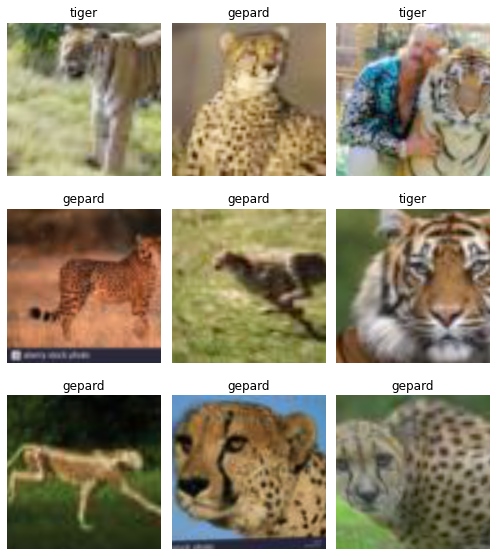

In [12]:
data.show_batch(rows=3, figsize=(7, 8))

<h2>Initializing the Learner</h2>

We will use Convolutional Neural net with Residual architecture and pretrained model. For every learning epoch we just want to see how precisse our model is and how big are train and valid losses.

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

We can try to fit our model with 5 epochs.

In [16]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.361452,3.143984,0.500000,00:05
1,1.081676,2.894429,0.500000,00:05
2,0.835785,1.370286,0.375000,00:05
3,0.719932,0.693230,0.250000,00:05
4,0.627177,0.321416,0.093750,00:05


We can see our model is doing pretty fine already so we should save it's parameters.

In [17]:
learn.save('stage-1')

We can try to learn the model a little bit more but after 2 more epochs it's valid loss starts to increase so is error rate. That's why here model is trained just 2 more epochs so it doesn't overfitt. It is matter of experiment how much model should be trained more because every time it generates new random batch.

In [27]:
learn = learn.load('stage-1')
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.096193,0.273831,0.093750,00:06
1,0.109680,0.214873,0.031250,00:06


Now we are sure our model is doing very good with accuracy of 96.88% and we should again save it's parameters. Remember, till now we trained just newly added fully connected layer for this problem.

In [28]:
learn.save('stage-2')

Now we should unfreeze the whole model and train all of it's parameters a little bit more. But first we are going to search for most proper learning rate.

In [ ]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


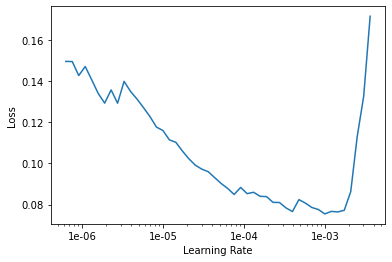

In [30]:
learn.recorder.plot()

We see that the most steepest part of graph is somewhere between 6e-06 and 9e-5 so we should take learning rate somewhere from this range.

In [35]:
learn = learn.load('stage-2')

Then we fit the whole model a little bit more. Again, it is matter of experiment, here is model trained one more epoch because more of that would cause overfitting. We can see the error rate didn't get any lower but at least validation loss is a little bit lower then from previos training epoch so it is at least a little progress. This model is already pretrained on ImageNet dataset so thats why there is no much space for progress.

In [36]:
learn.fit_one_cycle(1, max_lr=slice(6e-6, 9e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.153335,0.213015,0.031250,00:06


Then we save our final parameters and the model is ready for production.

In [37]:
learn.save('stage-3')

We can for example see the confusion matrix and the models performance. It is obvious that results are extraordinary with such a small amount of data. That is because we are using residual architecture with pretrained model which both improves the model greatly.

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

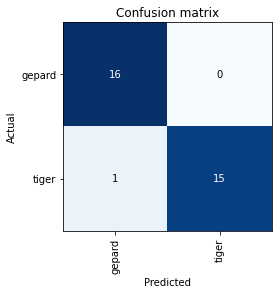

In [63]:
interp.plot_confusion_matrix()